**Michael Antunes - 2377042**

# **Objective**
* Predict Life Expectancy using SDG indicators as the features
* Perform Data preprocessing, exploratory data analysis, and building basic learning pipelines for linear regression and random forest regression models
* Analyse the model parameters and interpret their significance in relation to the SDGs and their impact on Life Expectancy.

# **Global Constants**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BDC Datasets"
DATASET_URL = "https://github.com/gtolomei/big-data-computing/raw/master/datasets/king-county-house-sales.csv.bz2"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/sdg2.csv"

RANDOM_SEED = 42 # for reproducibility

# **Spark + Google Colab Setup**

## **1.** Install PySpark and related dependencies

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=75df00671bd2c8fb4eb2cc21fe56c5e11596f571277d13f8323aa5f9868ad25f
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

## **2.** Import useful Python packages

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **3.** Create Spark context

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **4.** Link Colab to our Google Drive

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **5.** Check everything is ok

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.host', '1e7e1a2313ae'),
 ('spark.app.id', 'local-1685394402124'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.submitTime', '1685394400572'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.securi

# **1. Data Collection**

The dataset was collected from ["World Development Indicators DataBank"](https://databank.worldbank.org/source/world-development-indicators#) with the following filters :
* Period : 2000-2016
* Countries : low income, lower middle income, and upper middle income

The following Series was selected from the dataset :
- SDG 1: GNI per capita, PPP (current international $) (NY.GNP.PCAP.PP.CD)
- SDG 2: Prevalence of undernourishment (% of population) (SN.ITK.DEFC.ZS), Food production index (2014-2016 = 100) (AG.PRD.FOOD.XD)
- SDG 3: Prevalence of HIV, total (% of population ages 15-49) (SH.DYN.AIDS.ZS), Fertility rate, total (births per woman) (SP.DYN.TFRT.IN)
- SDG 4: School enrollment, primary (% net) (SE.PRM.NENR), School enrollment, secondary (% net) (SE.SEC.NENR)
- SDG 5: Labor force participation rate, female (% of female population ages 15+) (national estimate) (SL.TLF.CACT.FE.NE.ZS), Proportion of seats held by women in national parliaments (%) (SG.GEN.PARL.ZS)
- SDG 6: People using at least basic drinking water services (% of population)
- SDG 7: Access to electricity (% of population) (EG.ELC.ACCS.ZS)
- SDG 8: Unemployment with basic education (% of total labor force with basic education) (SL.UEM.BASC.ZS)
- SDG 11: Urban population (% of total population), Population living in slums (% of urban population) (EN.POP.SLUM.UR.ZS)
- SDG 12: Population density (people per sq. km of land area) (EN.POP.DNST)
- SDG 13: CO2 emissions (metric tons per capita) (EN.ATM.CO2E.PC)
- SDG 15: Forest area (% of land area) (AG.LND.FRST.ZS)
- SDG 17: Military expenditure (% of GDP) (MS.MIL.XPND.GD.ZS)
- Life expectancy at birth, total (years)

### **Download dataset file from URL directly to our Google Drive**

The dataset is saved to Google Drive as "SDG2.csv"

### **Read dataset file into a Spark Dataframe**

In [ ]:
sdg_df = spark.read.load(GDRIVE_DATASET_FILE,
                         format="csv",
                         sep=",",
                         inferSchema="true",
                         header="true"
                         )

# **2. Data Preprocessing**

### **Check the shape of the loaded dataset, i.e., number of rows and columns**

In [ ]:
print(f"The shape of the dataset is {sdg_df.count()} rows by {len(sdg_df.columns)} columns")

The shape of the dataset is 2312 rows by 23 columns


### **Print out the schema of the loaded dataset**

In [ ]:
sdg_df.printSchema()

root
 |-- Time: integer (nullable = true)
 |-- Time Code: string (nullable = true)
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Life expectancy at birth, total (years) [SP.DYN.LE00.IN]: string (nullable = true)
 |-- GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]: string (nullable = true)
 |-- Prevalence of undernourishment (% of population) [SN.ITK.DEFC.ZS]: string (nullable = true)
 |-- Food production index (2014-2016 = 100) [AG.PRD.FOOD.XD]: string (nullable = true)
 |-- Prevalence of HIV, total (% of population ages 15-49) [SH.DYN.AIDS.ZS]: string (nullable = true)
 |-- Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]: string (nullable = true)
 |-- School enrollment, primary (% net) [SE.PRM.NENR]: string (nullable = true)
 |-- School enrollment, secondary (% net) [SE.SEC.NENR]: string (nullable = true)
 |-- Labor force participation rate, female (% of female population ages 15+) (national estimate) [SL.TLF.

##Display the first 10 rows of the dataset

In [ ]:
sdg_df.show(10,False)

+----+---------+--------------+------------+--------------------------------------------------------+-----------------------------------------------------------------+-----------------------------------------------------------------+--------------------------------------------------------+----------------------------------------------------------------------+---------------------------------------------------------+------------------------------------------------+--------------------------------------------------+-------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+--------------------------------------------------------+------------------------------------------------------------------------------------------------+---------------------------------------------

## Rename the features to exclude the portion of the column name in  square-brackets

In [ ]:
column_names = [
    'Time',
    'Time Code',
    'Country Name',
    'Country Code',
    'Life expectancy at birth, total (years)',
    'GNI per capita, PPP (current international $)',
    'Prevalence of undernourishment (% of population)',
    'Food production index (2014-2016 = 100)',
    'Prevalence of HIV, total (% of population ages 15-49)',
    'Fertility rate, total (births per woman)',
    'School enrollment, primary (% net)',
    'School enrollment, secondary (% net)',
    'Labor force participation rate, female (% of female population ages 15+) (national estimate)',
    'Proportion of seats held by women in national parliaments (%)',
    'People using at least basic drinking water services (% of population)',
    'Access to electricity (% of population)',
    'Unemployment with basic education (% of total labor force with basic education)',
    'Urban population (% of total population)',
    'Population living in slums (% of urban population)',
    'Population density (people per square km of land area)',
    'CO2 emissions (metric tons per capita)',
    'Forest area (% of land area)',
    'Military expenditure (% of GDP)'
]
for i in range(len(sdg_df.columns)):
    sdg_df = sdg_df.withColumnRenamed(sdg_df.columns[i], column_names[i])

##Replace ".." with None values
The dataset represents null values as ".." therefore this value was replaced with `None` to facilitate data preprocessing

In [ ]:
sdg_df =sdg_df.replace('..',None)

## Display the count of Null values in each column

In [ ]:
sdg_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdg_df.columns]
   ).show()

+----+---------+------------+------------+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+----------------------------------+------------------------------------+--------------------------------------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------+-------------------------------------------------------------------------------+----------------------------------------+--------------------------------------------------+------------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+
|Time|Time Code|Country

##Drop Features with over 50% of their values missing
Using the above table, the below features were dropped due to a large portion of their values being missing. Large amounts of missing values for these features would result in underfitting as the model won't learn the significance of the feature. The following features were dropped:
* `Time` & `Time Code`- The model must learn based on the SDG indicators and not base predicions on the time period, as stated in the Objectives.
* `Country Name` & `Country Code` - The model must learn based on the SDG indicators and not base predicions on the Country, as stated in the  Objectives
* `Population living in slums (% of urban population)`
* `Unemployment with basic education (% of total labor force with basic education)`
* `School enrollment, secondary (% net)`
* `Labor force participation rate, female (% of female population ages 15+) (national estimate)`

In [ ]:
sdg_df = sdg_df.drop('Time Code')\
              .drop('Time')\
              .drop('Country Name')\
              .drop('Country Code')\
              .drop('Population living in slums (% of urban population)')\
              .drop('Unemployment with basic education (% of total labor force with basic education)')\
              .drop('School enrollment, secondary (% net)')\
              .drop('Labor force participation rate, female (% of female population ages 15+) (national estimate)')

## Remove remaining NULL entry/ies

In [ ]:
sdg_df = sdg_df.na.drop()

## Check for duplicated records

In [ ]:
print(f"The total number of duplicated records is {sdg_df.count()-sdg_df.dropDuplicates().count()}")

The total number of duplicated records is 0


## Display the shape of the dataset

In [ ]:
print(f"The shape of the dataset is {sdg_df.count()} rows by {len(sdg_df.columns)} columns")

The shape of the dataset is 848 rows by 15 columns


## **Dataset Shape and Schema**

The dataset contains **848**  records for the aforementioned features; each record, contains the following set of **15** columns:

- `Life expectancy at birth, total (years)`: Life expectancy at birth, total in years (numerical, continuous). **TARGET variable**
- `GNI per capita, PPP (current international $)`: Gross National Income (GNI) per capita, Purchasing Power Parity (PPP) in current international dollars (numerical, continuous)
- `Prevalence of undernourishment (% of population)`: Prevalence of undernourishment as a percentage of the population (numerical, continuous)
- `Food production index (2014-2016 = 100)`: Food production index for the years 2014-2016, with a base value of 100 (numerical, continuous)
- `Prevalence of HIV, total (% of population ages 15-49)`: Prevalence of HIV as a percentage of the population aged 15-49 (numerical, continuous)
- `Fertility rate, total (births per woman)`: Fertility rate, total number of births per woman (numerical, continuous)
- `School enrollment, primary (% net)`: Net enrollment rate for primary school as a percentage of the relevant age group (numerical, continuous)
- `Proportion of seats held by women in national parliaments (%)`: Proportion of seats held by women in national parliaments as a percentage (numerical, continuous)
- `People using at least basic drinking water services (% of population)`: Percentage of the population using at least basic drinking water services (numerical, continuous)
- `Access to electricity (% of population)`: Percentage of the population with access to electricity (numerical, continuous)
- `Urban population (% of total population)`: Urban population as a percentage of the total population (numerical, continuous)
- `Population density (people per square km of land area)`: Population density measured as the number of people per square kilometer of land area (numerical, continuous)
- `CO2 emissions (metric tons per capita)`: CO2 emissions per capita in metric tons (numerical, continuous)
- `Forest area (% of land area)`: Forest area as a percentage of the land area (numerical, continuous)
- `Military expenditure (% of GDP)`: Military expenditure as a percentage of Gross Domestic Product (GDP) (numerical, continuous)


## Change the dataframe schema to be float
By examining the dataframe earlier and the previous schema it was determined that all fields are numerical but were being stored as strings. Thus these fields were converted to floats as these models learn using numbers.

In [ ]:
for column in sdg_df.columns:
  sdg_df = sdg_df.withColumn(column, col(column).cast('float'))

## Display the first 5 rows of the dataset

In [ ]:
sdg_df.show(5, False)

+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+----------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------+----------------------------------------+------------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+
|Life expectancy at birth, total (years)|GNI per capita, PPP (current international $)|Prevalence of undernourishment (% of population)|Food production index (2014-2016 = 100)|Prevalence of HIV, total (% of population ages 15-49)|Fertility rate, total (births per woman)|School enrollment, primary (% net)|Proportion of seats

# **3. Exploratory Data Analysis (EDA)**

Visualise and compute statistics of dataset.  

### **Summary of Descriptive Statistics**

In [ ]:
sdg_df.describe().show()

+-------+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+----------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------+----------------------------------------+------------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+
|summary|Life expectancy at birth, total (years)|GNI per capita, PPP (current international $)|Prevalence of undernourishment (% of population)|Food production index (2014-2016 = 100)|Prevalence of HIV, total (% of population ages 15-49)|Fertility rate, total (births per woman)|School enrollment, primary (% net)|Pro

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
sdg_pdf = sdg_df.toPandas()

In [ ]:
# Set some default plotting configuration using seaborn properties
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2,
                                "xtick.labelsize":14,
                                "ytick.labelsize":14,
                                "axes.labelsize": 16
                                })

### **Distribution Plots**

This set of plots will show the distribution of values of a subset of **14** Features. This provides insight about how the features are distributed. If certain features are skewed, model performance can be affected, as the model won't accurately learn the relationship with the target variable.

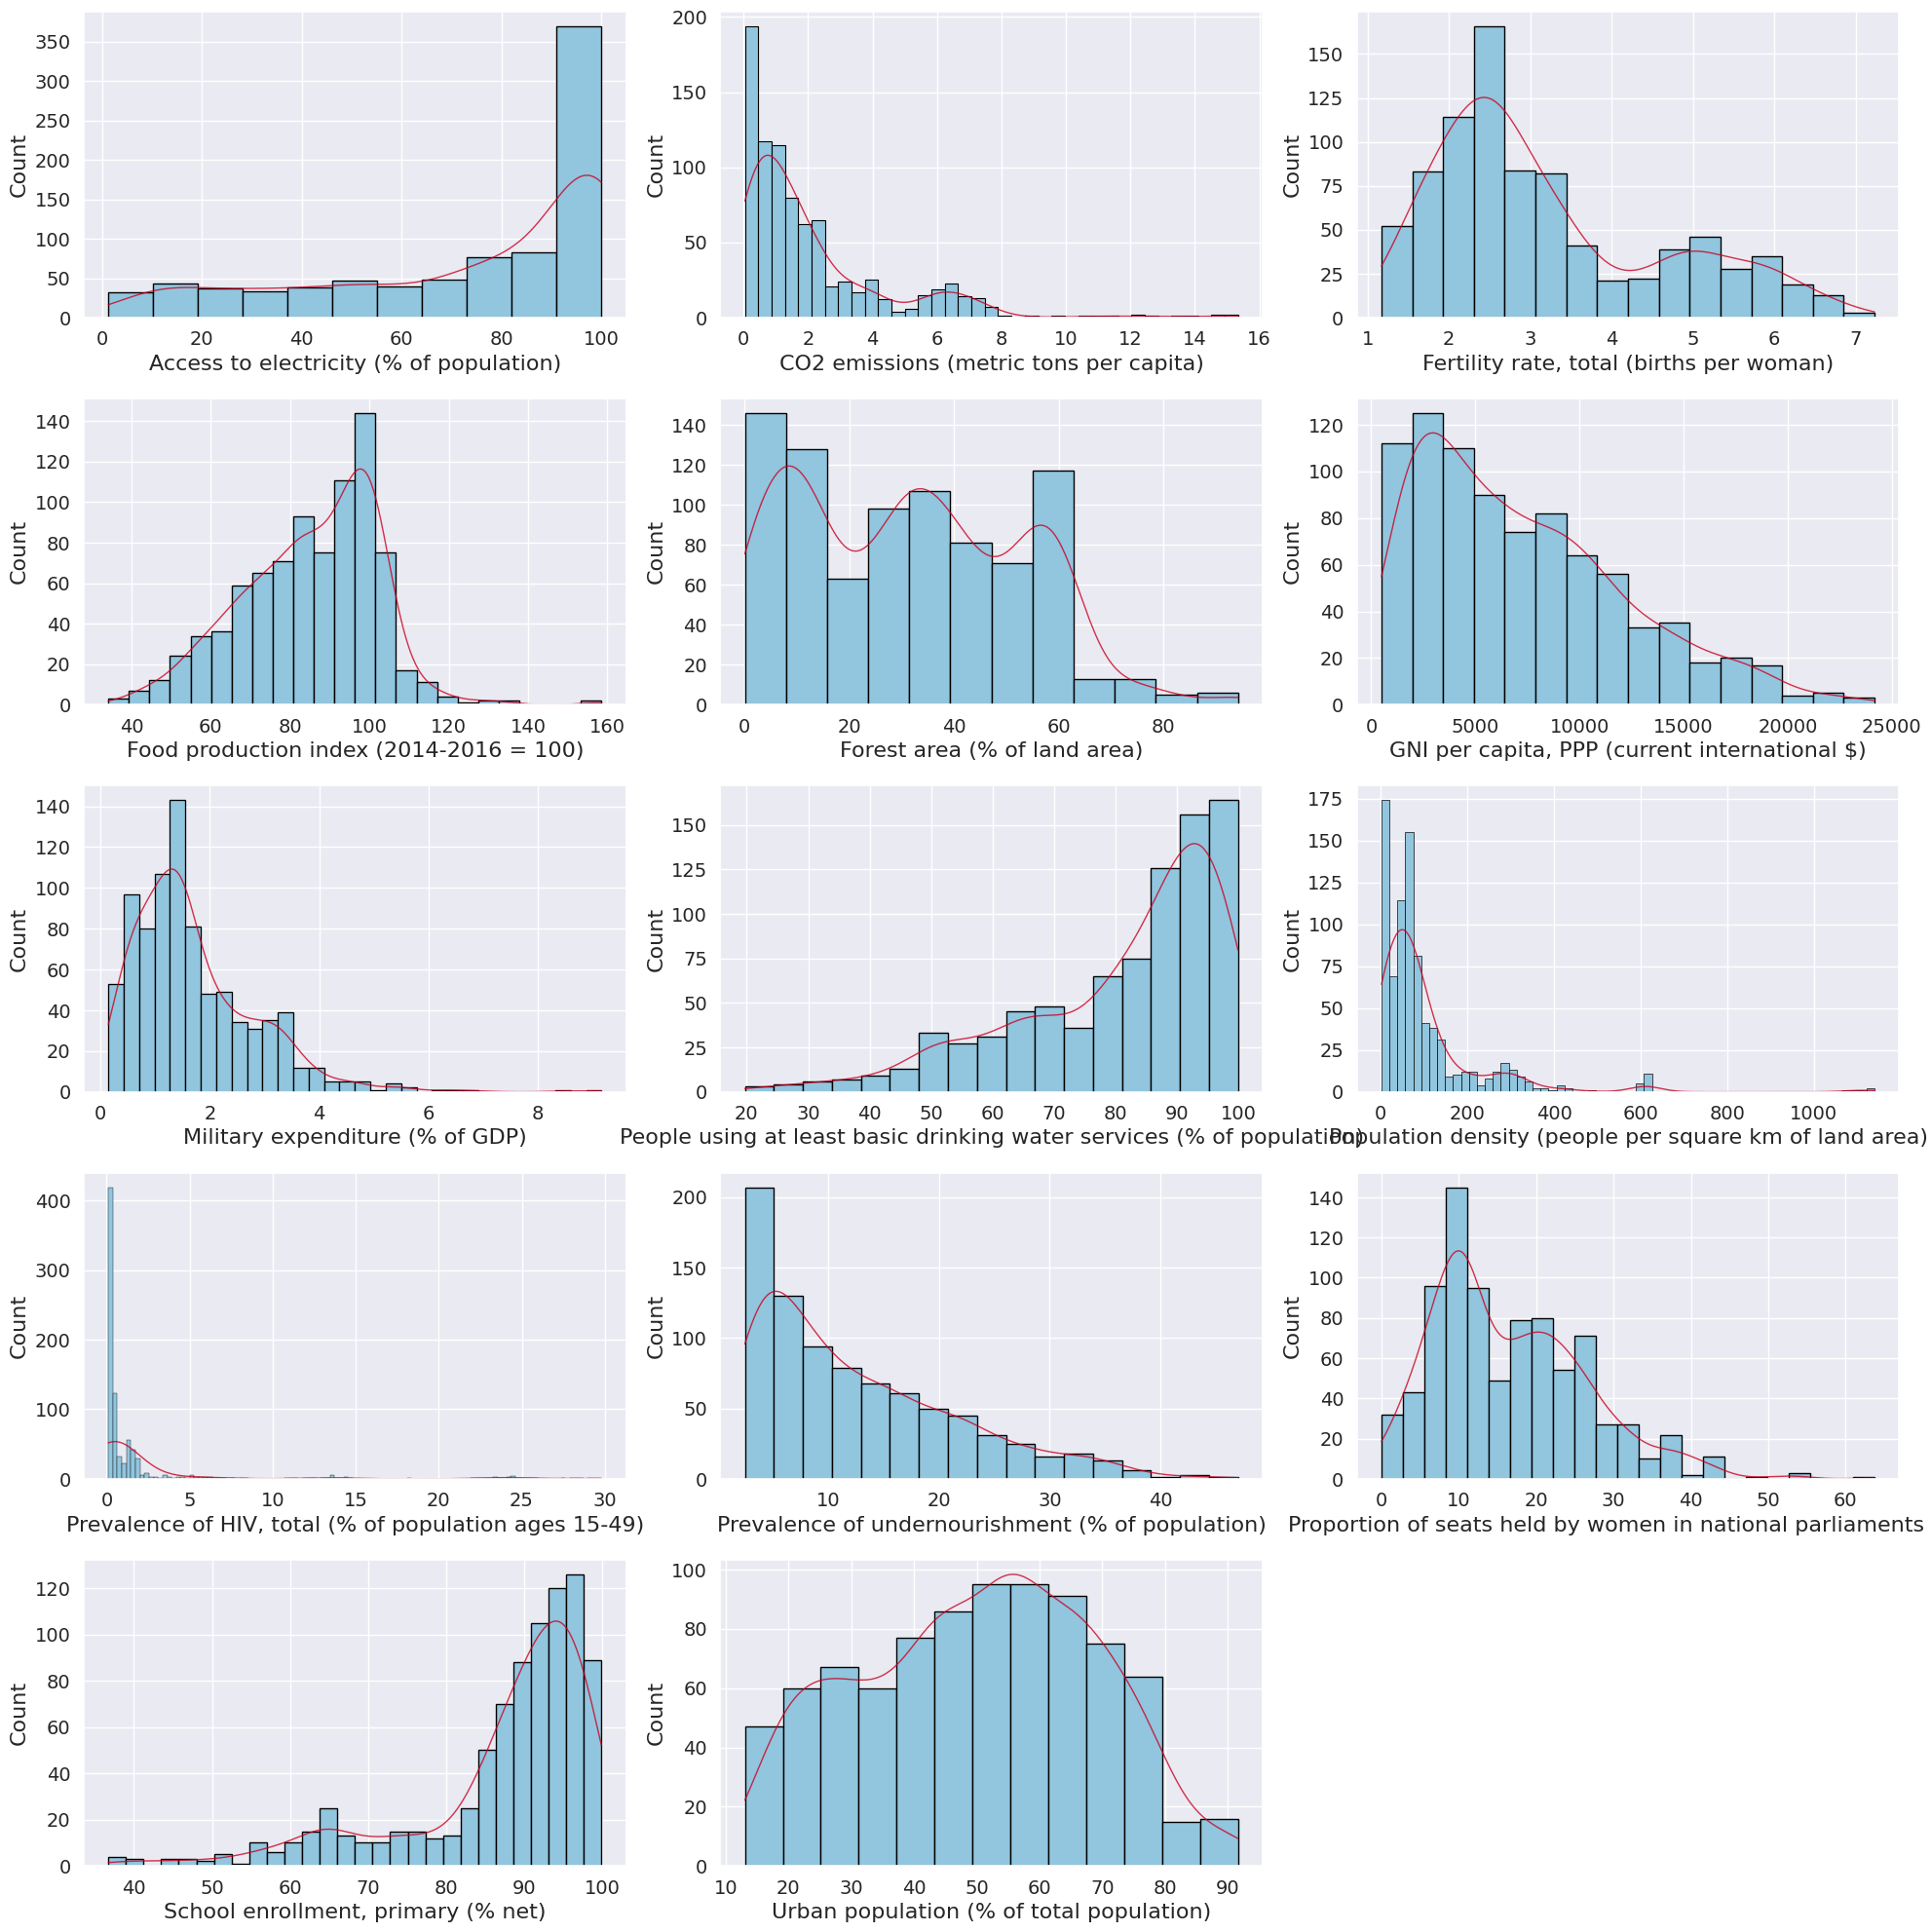

In [ ]:
fig, axes = plt.subplots(5,3, figsize=(20,20))
axes = axes.flatten()
fig.delaxes(axes[14])
col_to_plot = sorted(sdg_pdf.columns[1:])

for i,feature_name in enumerate(col_to_plot):
  ax = sns.histplot(sdg_pdf[feature_name],
                   kde=True,
                   color="#ca0020",
                   line_kws={"linewidth": 1, "alpha": 0.8},
                   facecolor="#92c5de",
                   edgecolor="black",
                   ax=axes[i]
                   )

fig.tight_layout()

### **Relationship between _numerical continuous_ features and the _target variable_ (`Life expectancy at birth, total (years)`)**

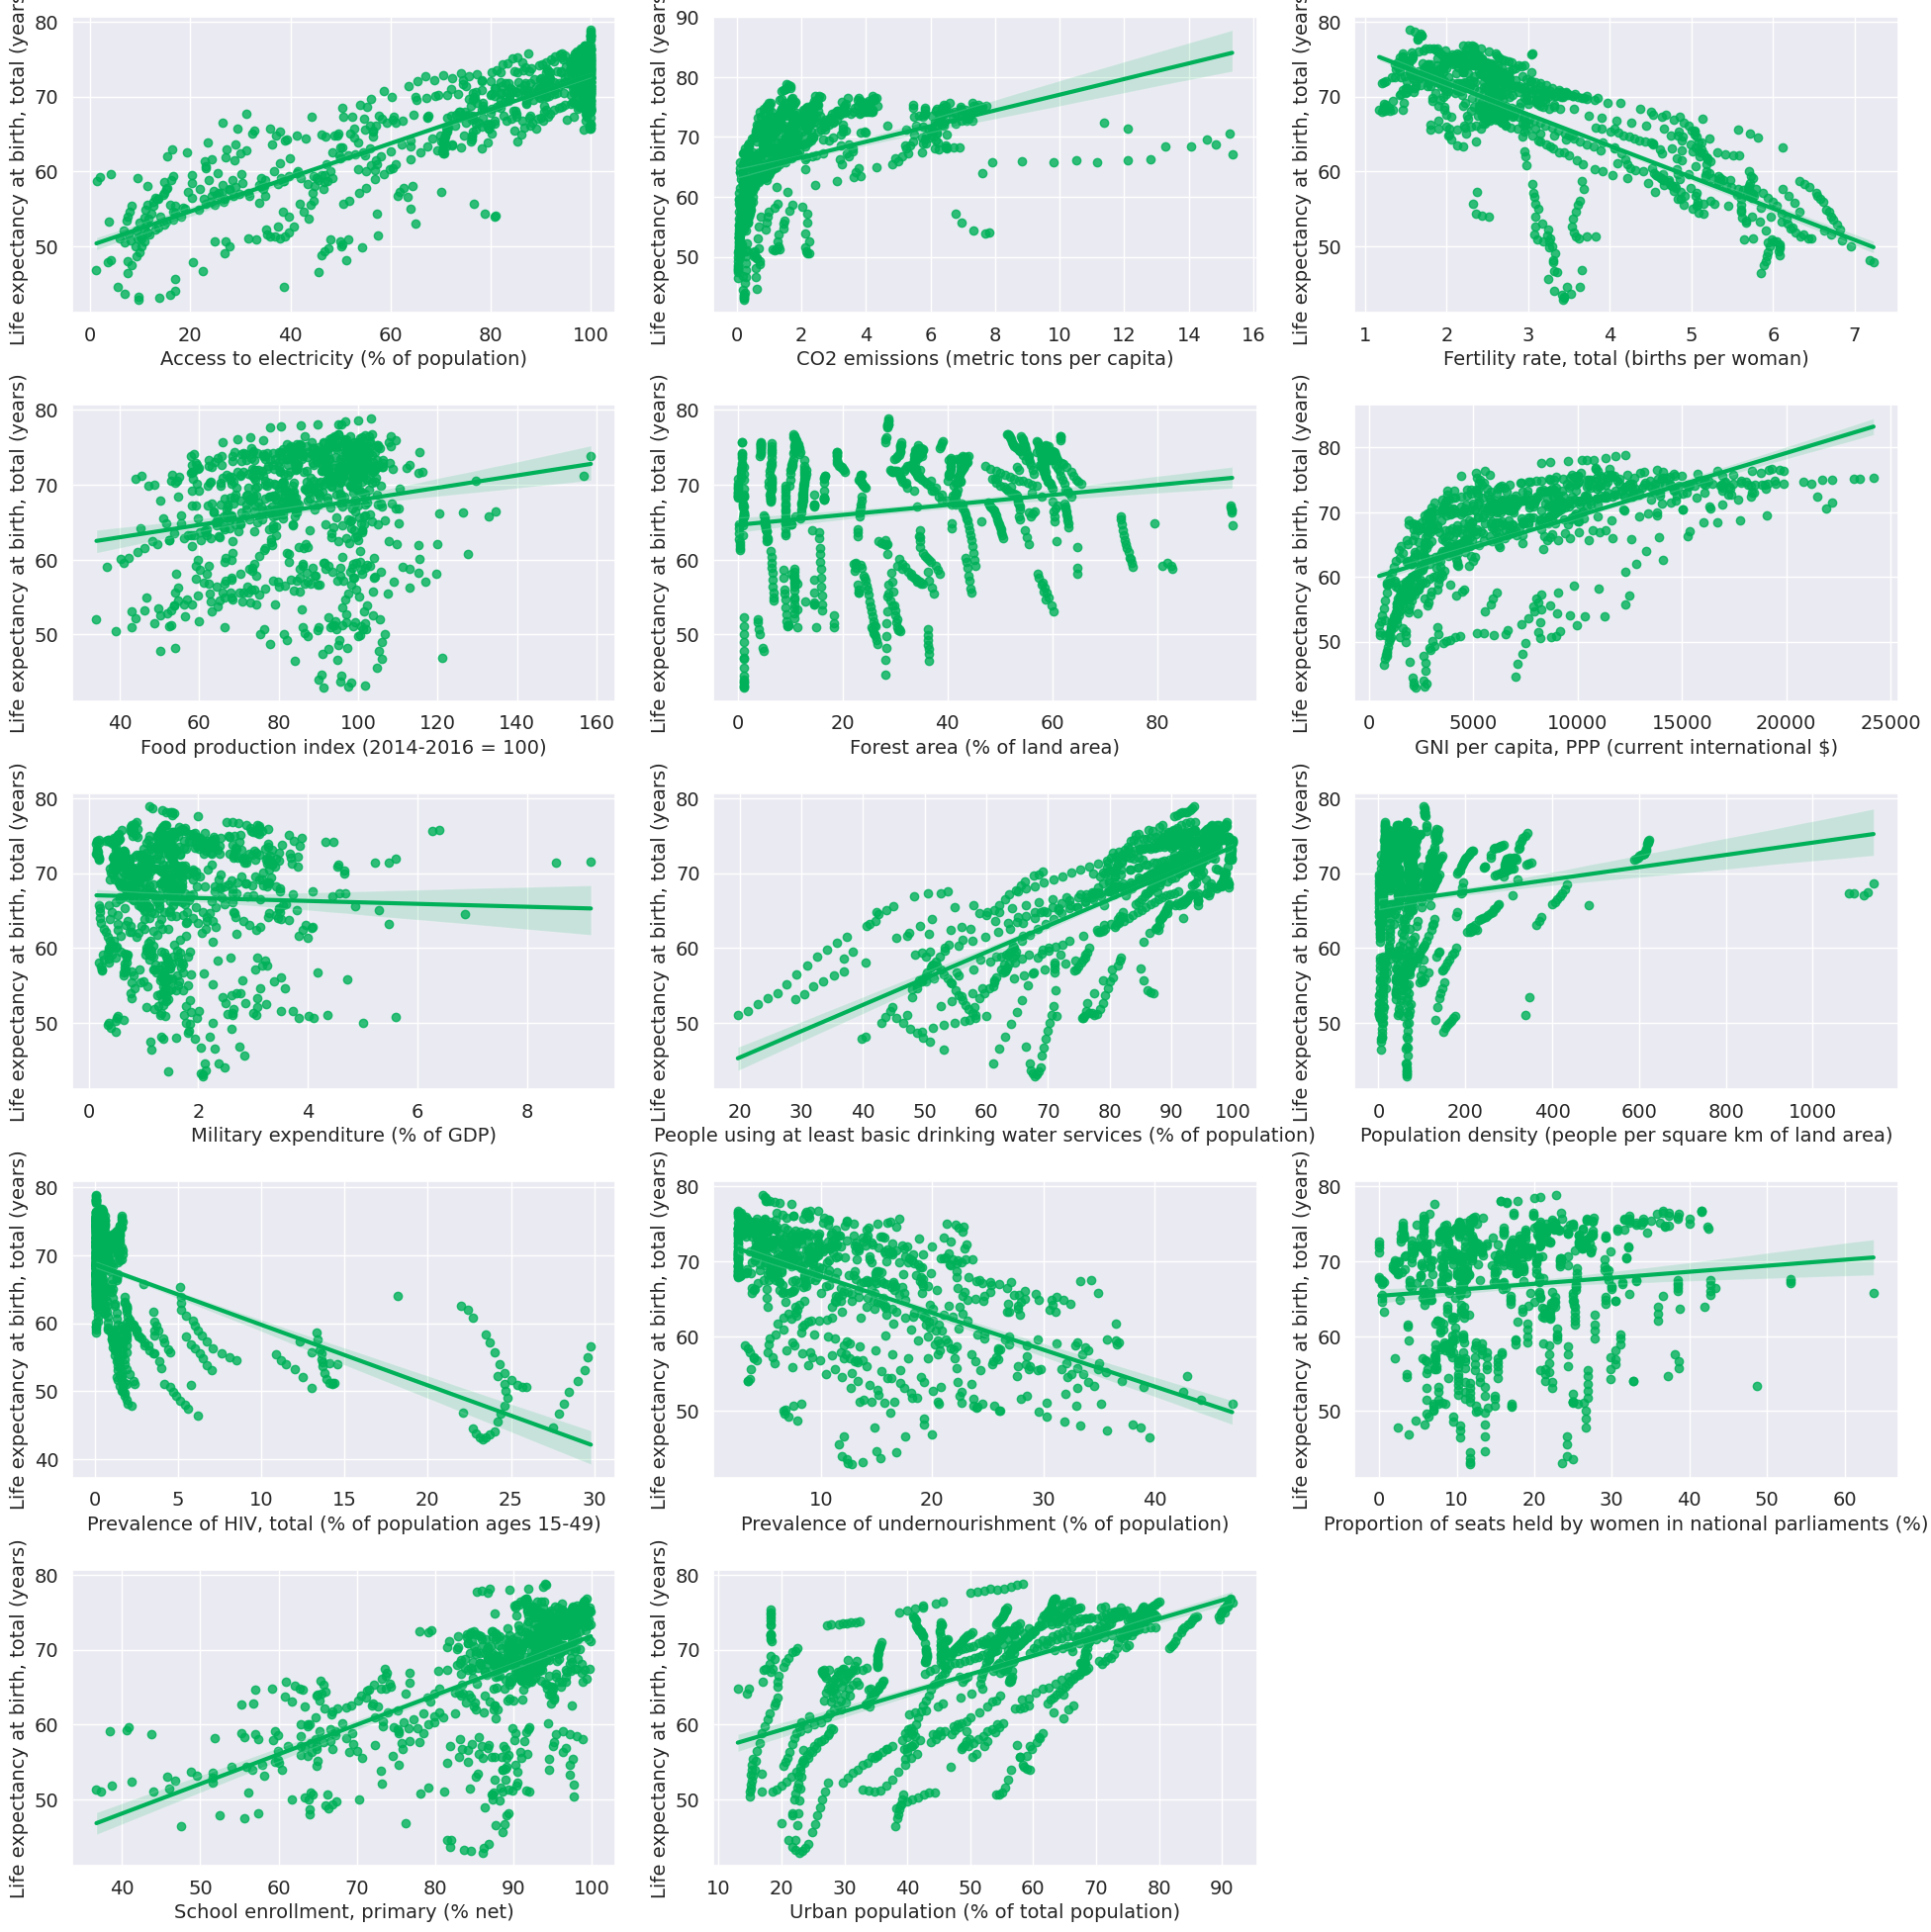

In [ ]:
# Plot the relationship between each continuous feature (i.e., independent variable) with the target (i.e., dependent) variable
sns.set_context("notebook", rc={"lines.linewidth": 2,
                                "xtick.labelsize":14,
                                "ytick.labelsize":14,
                                "axes.labelsize": 14
                                })

fig, axes = plt.subplots(5, 3, figsize=(20,20))
axes = axes.flatten()
fig.delaxes(axes[14])
col_to_plot = sorted(sdg_pdf.columns[1:])


for i,feature in enumerate(col_to_plot):
  ax = sns.regplot(data=sdg_pdf,
                  x=feature,
                  y="Life expectancy at birth, total (years)",
                  color="#00b159",
                  ax=axes[i]
  )
fig.tight_layout(pad=2.0)

##Boxplot of features

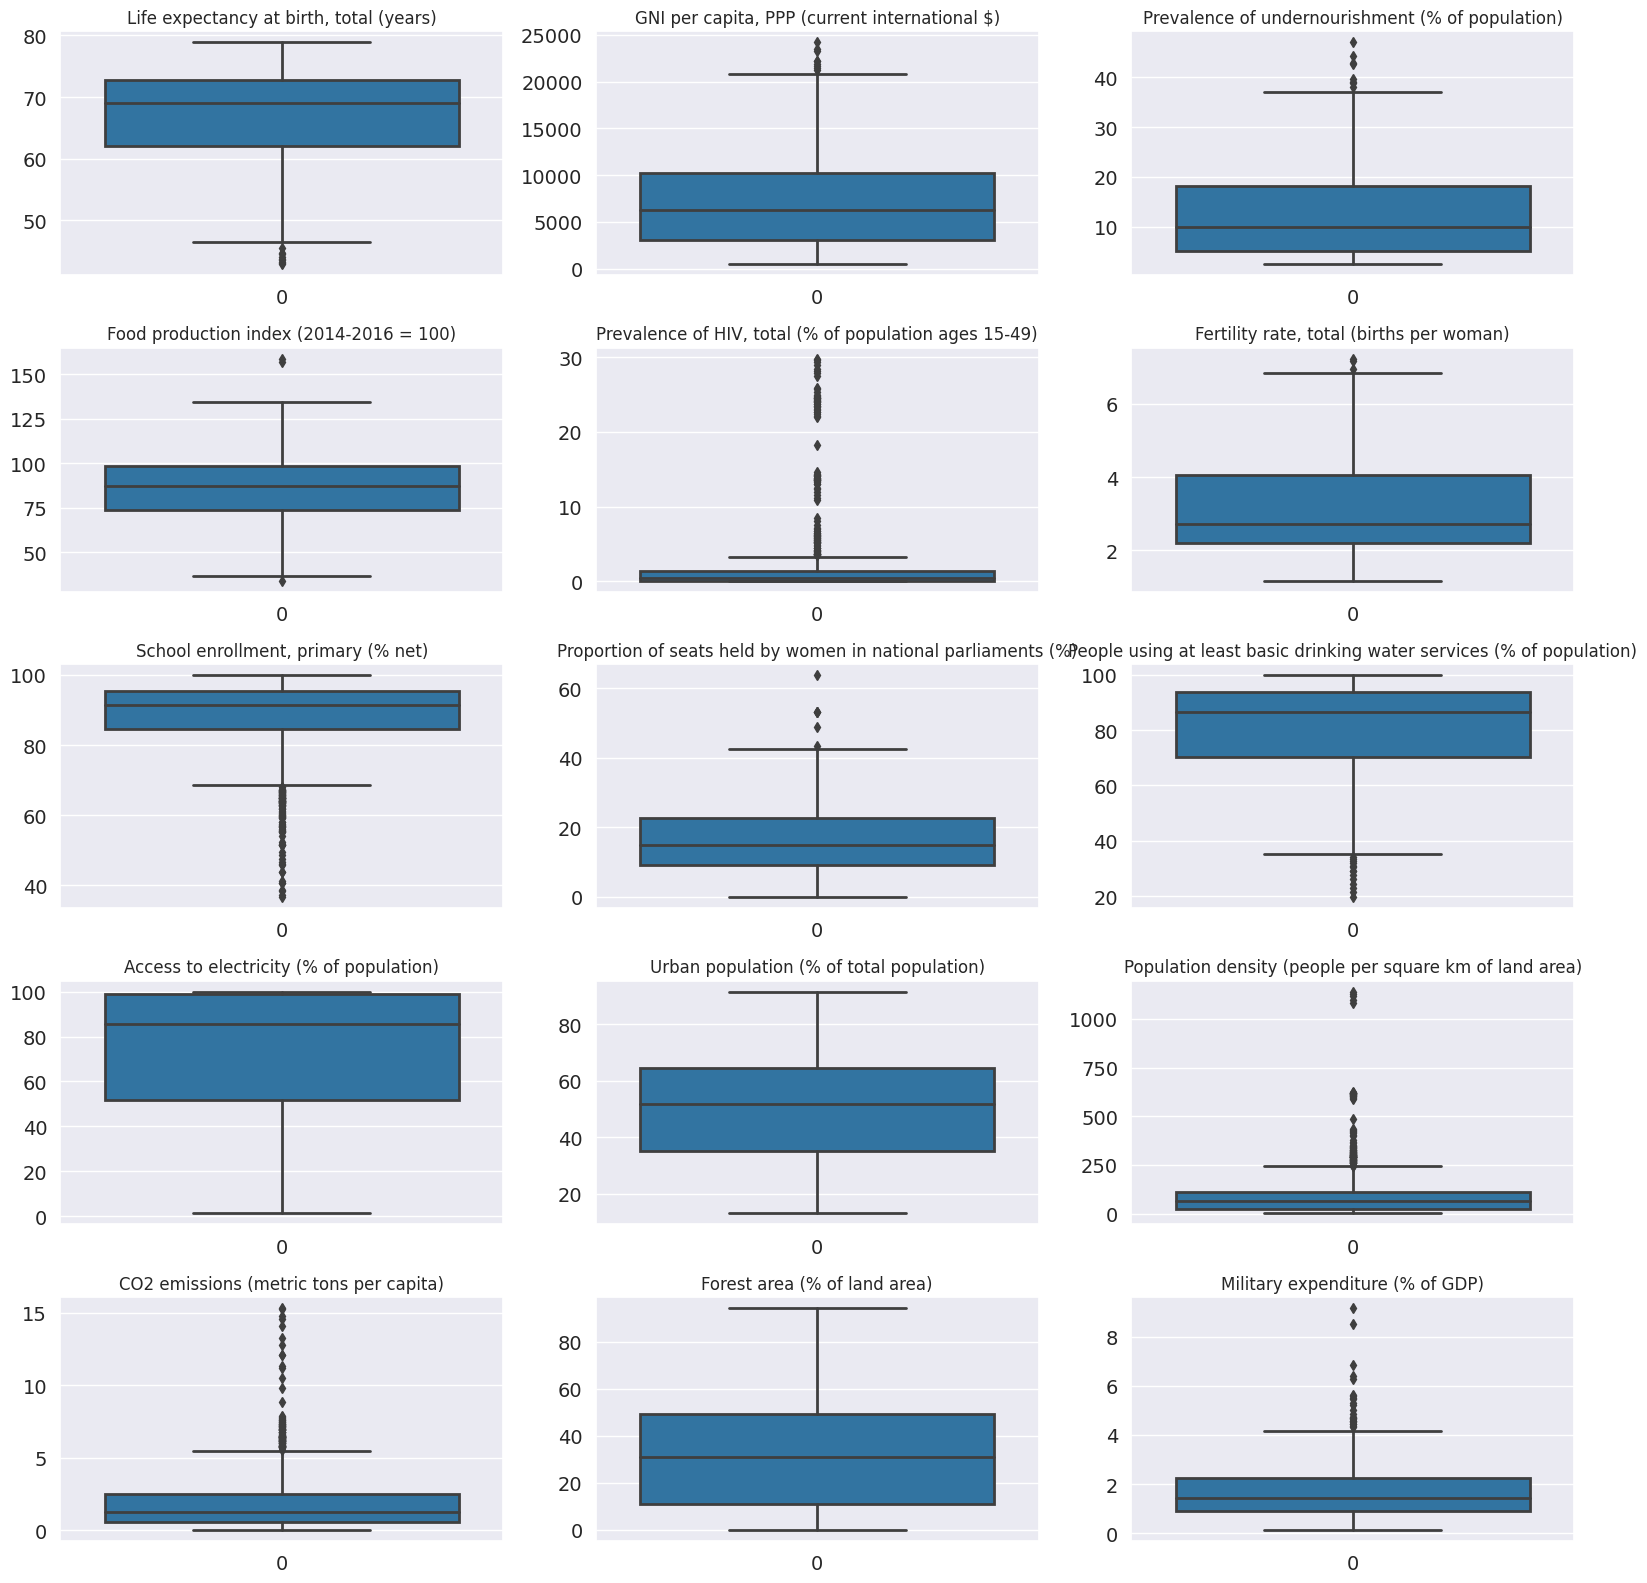

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(16,16))
axes = axes.flatten()

for i,feature in enumerate(sdg_pdf.columns):
  sns.boxplot(sdg_pdf[feature],ax=axes[i]
  )
  axes[i].set_title(f'{feature}')
  fig.tight_layout()


#### **Observations**

It seems there is a **moderate** linear relationship between these features and  `life expectancy`:
* `access to electricity`
* `access to basic drinking water`
* `School enrollment, primary`

There is also an inverse linear relationship between `fertility rate` and `life expectancy`. Most of the other features don't have much of a linear relationship. This is confirmed in the heatmap below.

### **Notes on Correlation between features**

* Too many features might cause **overfitting**. Thus, if a feature does not improve our model performance a lot, removing it may indeed be a better choice.

* Very high **correlation** between a subset of features is also likely to cause **overfitting**. The correlation between the highly-correlated features does not provide much improvement in the model's peformance as each feature can be easily derived from the other. Contrastingly, there are cases where these features might capture different aspects of the domain objects and thus improve the model's performance


### **Pearson Correlation Coefficient and Correlation Matrix**


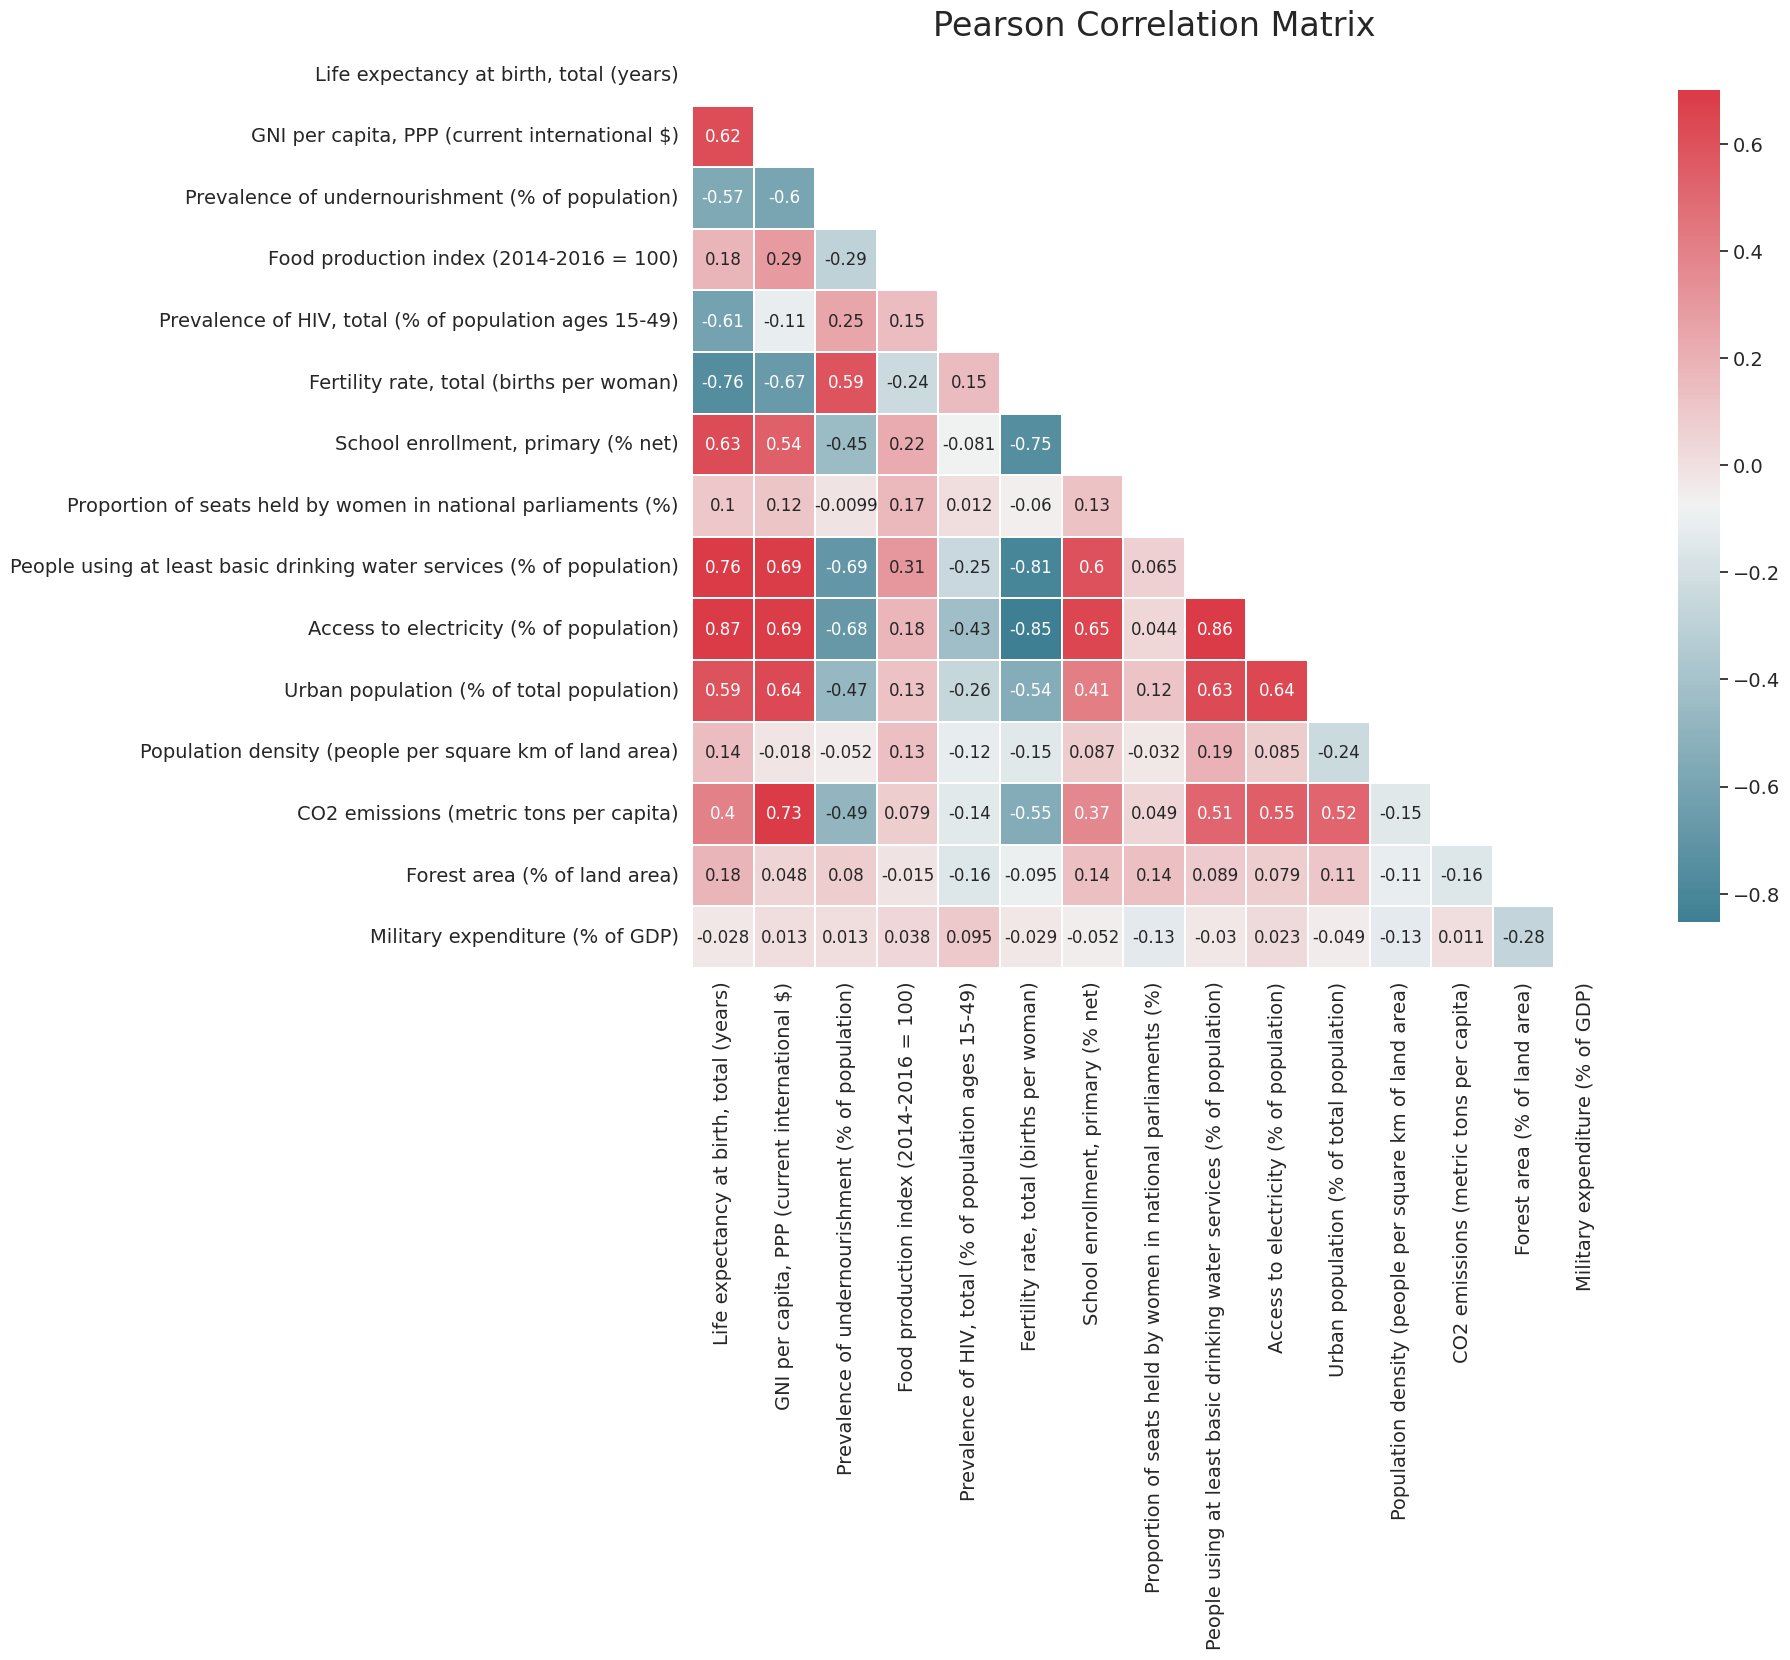

In [ ]:
import numpy as np

#calculate correlation matrix.
#np.zeros_like() creates a new array of the same shape as the correlation matrix, but filled with zeros.
mask = np.zeros_like(sdg_pdf.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True  #mask that covers upper triangular part

with sns.axes_style("white"): # Temporarily set the background to white
  fig, ax = plt.subplots(figsize=(16, 12))
  plt.title('Pearson Correlation Matrix', fontsize=24)

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  _ = sns.heatmap(sdg_pdf.corr(),
              linewidths=0.25,
              vmax=0.7,
              square=True,
              ax=ax,
              cmap=cmap,
              linecolor='w',
              annot=True,
              annot_kws={"size":12},
              mask=mask,
              cbar_kws={"shrink": .9});

#### **Observations**

* `Access to electricity` and `people using atleast basic drinking water` are high-positively correlated with each other ($\rho = 0.86$)
* `GNI per capita, PPP` and `CO2 emissions` are also highly correlated with a coefficient ($\rho=0.73$)
* `Access to electricity` has the highest correlation with the target variable ($\rho =0.87$)

# **4. Experimenting with Linear Regression Pipeline**


**General principle: anything we learn must be learned from the model's training data.**

### **Random Dataset Splitting: Training and Test Set**

- _training set_ = 90% of dataset
- _test set_ 10% of dataset

In [ ]:
train_df, test_df = sdg_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

In [ ]:
train_df.columns

['Life expectancy at birth, total (years)',
 'GNI per capita, PPP (current international $)',
 'Prevalence of undernourishment (% of population)',
 'Food production index (2014-2016 = 100)',
 'Prevalence of HIV, total (% of population ages 15-49)',
 'Fertility rate, total (births per woman)',
 'School enrollment, primary (% net)',
 'Proportion of seats held by women in national parliaments (%)',
 'People using at least basic drinking water services (% of population)',
 'Access to electricity (% of population)',
 'Urban population (% of total population)',
 'Population density (people per square km of land area)',
 'CO2 emissions (metric tons per capita)',
 'Forest area (% of land area)',
 'Military expenditure (% of GDP)']

## **The Univariate Linear Regression Model**

Build a model using the feature that is the most correlated to `Life expectancy at birth, total (years)`. This was seen to be `Access to electricity`.

Our linear regression model would thus look like the following:

$$
\underbrace{h_{\theta}(x)}_{\texttt{Life expectancy at birth, total (years)}} = \theta_0 + \theta_1 \cdot \underbrace{x}_{\texttt{Access to electricity}}
$$

### **Extract a single predictor variable and the target variable using Feature Transformer**

In [ ]:
#VectorAssembler is a transformer that combines a given list of columns into a
# single vector column
from pyspark.ml.feature import VectorAssembler

#extract 'Access to electricity' and transform it to a vector column called features
assembler = VectorAssembler(inputCols=['Access to electricity (% of population)'],
                            outputCol="features")

simple_train_df = assembler.transform(train_df)
simple_train_df.show(5)

+---------------------------------------+---------------------------------------------+------------------------------------------------+---------------------------------------+-----------------------------------------------------+----------------------------------------+----------------------------------+-------------------------------------------------------------+---------------------------------------------------------------------+---------------------------------------+----------------------------------------+------------------------------------------------------+--------------------------------------+----------------------------+-------------------------------+--------------------+
|Life expectancy at birth, total (years)|GNI per capita, PPP (current international $)|Prevalence of undernourishment (% of population)|Food production index (2014-2016 = 100)|Prevalence of HIV, total (% of population ages 15-49)|Fertility rate, total (births per woman)|School enrollment, primary (% net

In [ ]:
# Select only the two columns which we are interested in, i.e., `features` and `life expectancy`
simple_train_df = simple_train_df.select(["features", "Life expectancy at birth, total (years)"])
simple_train_df.show(5, truncate=False)

+--------------------+---------------------------------------+
|features            |Life expectancy at birth, total (years)|
+--------------------+---------------------------------------+
|[9.699999809265137] |42.914                                 |
|[13.877540588378906]|43.123                                 |
|[9.667811393737793] |43.233                                 |
|[15.991896629333496]|43.566                                 |
|[6.800000190734863] |43.711                                 |
+--------------------+---------------------------------------+
only showing top 5 rows



### **Training a simple univariate OLS linear regressor (with no regularization $\lambda =0$)**

In [ ]:
from pyspark.ml.regression import LinearRegression

# First of all, let's just setup a very basic univariate OLS linear regressor (since regTerm=0)
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy at birth, total (years)")
lr_model = lr.fit(simple_train_df)

#### **Intercept ($\theta_0$) and Coefficient ($\theta_1$)**

In [ ]:
print("Intercept: " + str(lr_model.intercept))
print("Coefficient: " + str(lr_model.coefficients))

Intercept: 50.109702985960354
Coefficient: [0.22729552658039115]


#### **Measuring performance on the Training Set: $\text{RMSE}$ and $\text{R}^2$ statistic**
* Lower RMSE is better
* $\text{R}^2$ score measures how well the model predicts the data points. A score a of 1 is the best
  * $\text{R}^2$ increases with every predictor added to a model
* Adjusted $\text{R}^2$  is also a measure of model performance, but it adjusts for the number of terms in a model.
  * Adjusted $\text{R}^2$ will penalise the score for adding independent variables that do not fit the model, thus adjusted  $\text{R}^2$ will decrease.
  * If you add more useful variables, adjusted $\text{R}^2$ will increase.
  * Adjusted $\text{R}^2$ will always be less than or equal to $\text{R}^2$.

In [ ]:
training_result = lr_model.summary
print("***** Training Set *****")
print(f"RMSE: {training_result.rootMeanSquaredError:.3f}")
print(f"R2: {training_result.r2:.3f}")
print(f"Adjusted R2: {training_result.r2adj:.3f}")

***** Training Set *****
RMSE: 3.878
R2: 0.755
Adjusted R2: 0.754


### **Testing the simple univariate OLS linear regressor learned above on the Test Set**

In [ ]:
#extract same feature from the test set, which will be used in the test prediction
assembler = VectorAssembler(inputCols=["Access to electricity (% of population)"],
                            outputCol="features")

simple_test_df = assembler.transform(test_df)

In [ ]:
# `lr_model` is a Transformer which has been trained on the train set, which can be used to "transform" our test set
lr_predictions = lr_model.transform(simple_test_df) # adds predictions to column called prediction

In [ ]:
# `lr_predictions` is a dataframe containing (among other things) the predictions made by `lr_model` on the test set
lr_predictions.select("features", "prediction", "Life expectancy at birth, total (years)").show(5)

+--------------------+------------------+---------------------------------------+
|            features|        prediction|Life expectancy at birth, total (years)|
+--------------------+------------------+---------------------------------------+
| [5.465812683105469]|51.352057757956594|                                  44.53|
|              [17.0]|   53.973726937827|                                 45.596|
|[35.966861724853516]|58.284809761155046|                                  51.26|
| [6.696063041687012]|51.631688161036095|                                 52.044|
|[18.226219177246094]|54.252441071422126|                                 54.003|
+--------------------+------------------+---------------------------------------+
only showing top 5 rows



#### **Measuring performance on the Test Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
test_result = lr_model.evaluate(simple_test_df)
print("***** Test Set *****")
print(f"RMSE: {test_result.rootMeanSquaredError:.3f}")
print(f"R2: {test_result.r2:.3f}")
print(f"Adjusted R2: {test_result.r2adj:.3f}".format(test_result.r2adj))

***** Test Set *****
RMSE: 3.255
R2: 0.809
Adjusted R2: 0.806


#### **Observations**

The simple univariate linear regressor does not work well compared to a multivariable regressor model. This may be due to the fact that a single explanatory variable (feature) not being sufficient to entirely explain the `Target` variable

Also, the fact that both $R^2$ and $R^2_{\text{adj}}$ are slightly better on the test set than on the training set may be simply due to a "lucky" random split of the initial , this can be mitigated using cross validation.

## **Multivariate Linear Regressor using OLS optimisation**

use VectorAssembler to convert all feature columns into one vector column

In [ ]:
assembler = VectorAssembler(inputCols=sdg_df.columns[1:],
                            outputCol = 'features')
train = assembler.transform(train_df)
train = train.select(['features','Life expectancy at birth, total (years)'])
train.show(10)

+--------------------+---------------------------------------+
|            features|Life expectancy at birth, total (years)|
+--------------------+---------------------------------------+
|[2220.0,12.800000...|                                 42.914|
|[2650.0,12.399999...|                                 43.123|
|[2150.0,13.699999...|                                 43.233|
|[2760.0,12.300000...|                                 43.566|
|[2130.0,15.300000...|                                 43.711|
|[2640.0,11.899999...|                                 44.034|
|[7040.0,15.0,90.7...|                                 44.639|
|[710.0,39.5999984...|                                 46.433|
|[7140.0,17.600000...|                                 46.619|
|[2700.0,12.0,106....|                                 46.692|
+--------------------+---------------------------------------+
only showing top 10 rows



### **Training an OLS Multivariate Linear Regressor (with no regularization) using all the features**

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="Life expectancy at birth, total (years)")
lr_model = lr.fit(train)

### **Intercept ($\theta_0$) and Coefficients ($\theta_1, \ldots, \theta_n$)**

In [ ]:
print("Intercept: " + str(lr_model.intercept))
print("Coefficients: " + str(lr_model.coefficients))

Intercept: 54.46094527816731
Coefficients: [0.00037568453720159716,0.05743838592517037,0.01881065398019575,-0.6760683386960276,-1.6672770207481695,0.07532570523799005,0.030508240885487377,0.04962054853022681,0.05811708172544988,0.010888346773361606,-0.0017651375199817694,-0.7216146821478413,-0.0067957117389170546,0.05648001205249595]


#### **Measuring performance on the Training Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
training_result = lr_model.summary
print("***** Training Set *****")
print(f"RMSE: {training_result.rootMeanSquaredError:.3f}")
print(f"R2: {training_result.r2:.3f}")
print(f"Adjusted R2: {training_result.r2adj:.3f}")

***** Training Set *****
RMSE: 2.474
R2: 0.900
Adjusted R2: 0.898


### **Compute predictions on the Test Set according to the model learned on the Training Set**

In [ ]:
#apply same transformer that we applied to train set
test = assembler.transform(test_df)
test = test.select(['features','Life expectancy at birth, total (years)'])
# `lr_model` is a Transformer which has been trained on the train set, which can be used to "transform" our test set
lr_predictions =lr_model.transform(test)
lr_predictions.select("features",'prediction','Life expectancy at birth, total (years)').show(5)

+--------------------+------------------+---------------------------------------+
|            features|        prediction|Life expectancy at birth, total (years)|
+--------------------+------------------+---------------------------------------+
|[2110.0,16.799999...| 46.85043287672873|                                  44.53|
|[2730.0,11.600000...| 48.28079316405408|                                 45.596|
|[5180.0,13.5,95.8...|55.835341917084975|                                  51.26|
|[1040.0,22.5,34.1...| 49.26604164345983|                                 52.044|
|[1430.0,13.300000...| 53.35223835815613|                                 54.003|
+--------------------+------------------+---------------------------------------+
only showing top 5 rows



#### **Measuring performance on the Test Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
test_result = lr_model.evaluate(test)
print("***** Test Set *****")
print(f"RMSE: {test_result.rootMeanSquaredError:.3f}")
print(f"R2: {test_result.r2:.3f}")
print(f"Adjusted R2: {test_result.r2adj:.3f}".format(test_result.r2adj))

***** Test Set *****
RMSE: 2.447
R2: 0.892
Adjusted R2: 0.863


###**Observations**
The multivariate linear regressor performed significantly better than the univariate model. This can be attributed to the the importance of the other features having influence in the prediction of the target variable.

### **Standardize Features**

* The boxplots earlier highlighted the diffferent scales of the different features. To improve performance, a feature scaling transformer is used to standardize all the features to 0-mean and 1-unit of standard deviation.
* Can help numerical methods converge faster



In [ ]:
def standardize_features(df, input_col="features", with_std=True, with_mean=True):
    from pyspark.ml.feature import StandardScaler
    scaler = StandardScaler(inputCol=input_col, outputCol="std_"+input_col, withStd=with_std, withMean=with_mean)
    # 2. Compute summary statistics by fitting the StandardScaler
    scaler_model = scaler.fit(df)
    # 3. Normalize each feature to have 0-mean and unit standard deviation
    scaled_data = scaler_model.transform(df)
    # 4. return scaler_model (for future transformations) and the scaled data
    return scaler_model, scaled_data

#### **Measuring performance on the Scaled Training Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
train = train.withColumnRenamed('Life expectancy at birth, total (years)','label')#rename target variable to "label"
train.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[2220.0,12.800000...|42.914|
|[2650.0,12.399999...|43.123|
|[2150.0,13.699999...|43.233|
|[2760.0,12.300000...|43.566|
|[2130.0,15.300000...|43.711|
+--------------------+------+
only showing top 5 rows



In [ ]:
scaler_model, scaled_train = standardize_features(train)
scaled_train.select(["features", "std_features", "label"]).show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                                                                                                                                                                 |std_features                                                                                                                                                                                                     

In [ ]:
lr = LinearRegression(featuresCol="std_features", labelCol="label")
lr_model = lr.fit(scaled_train)

In [ ]:
training_result = lr_model.summary
print("***** Training Set *****")
print(f"RMSE: {training_result.rootMeanSquaredError:.3f}")
print(f"R2: {training_result.r2:.3f}")
print(f"Adjusted R2: {training_result.r2adj:.3f}")

***** Training Set *****
RMSE: 2.474
R2: 0.900
Adjusted R2: 0.898


#### **Measuring performance on the Scaled Test Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
test = test.withColumnRenamed('Life expectancy at birth, total (years)','label')
scaled_test = scaler_model.transform(test)
lr_predictions = lr_model.transform(scaled_test)
lr_predictions.select("features", "std_features", "prediction", "label").show(5)

+--------------------+--------------------+-----------------+------+
|            features|        std_features|       prediction| label|
+--------------------+--------------------+-----------------+------+
|[2110.0,16.799999...|[-1.0277138458863...|46.85043287672969| 44.53|
|[2730.0,11.600000...|[-0.9038233571466...|48.28079316405454|45.596|
|[5180.0,13.5,95.8...|[-0.4142561032557...| 55.8353419170851| 51.26|
|[1040.0,22.5,34.1...|[-1.2415248506468...|49.26604164346106|52.044|
|[1430.0,13.300000...|[-1.1635937367621...|53.35223835815835|54.003|
+--------------------+--------------------+-----------------+------+
only showing top 5 rows



In [ ]:
test_result = lr_model.evaluate(scaled_test)
print("***** Test Set *****")
print(f"RMSE: {test_result.rootMeanSquaredError:.3f}")
print(f"R2: {test_result.r2:.3f}")
print(f"Adjusted R2: {test_result.r2adj:.3f}".format(test_result.r2adj))

***** Test Set *****
RMSE: 2.447
R2: 0.892
Adjusted R2: 0.863


###Observations
* Since we are using simple OLS linear regression we obtain exactly the same result whether we do feature scaling or not.
* regParams of 0.3,0.5 and 1.2 were tested which resulted in worse model performance
* Thus no standardisation will be used


## Linear Regressor with all features and K-fold Cross Validation
* paramGrid is to create a grid of parameters used to search for the best hyperparameters namely :  
  * lr.regParam ($\lambda$)
  * lr.elasticNetParam ($\alpha$),
* K-fold CV gives a better estimation of model performance and will thus be used to evaluate the model using RMSE evaluator
  * 5-fold CV will be used to evaluate the models performance using the hyperparameters in the paramGrid



In [ ]:
def linear_regression_pipeline(train,
                               k_fold=5):

    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml import Pipeline

    assembler = VectorAssembler(inputCols=sdg_df.columns[1:], #index 0 is target
                                outputCol="features")

    train = train.withColumnRenamed("Life expectancy at birth, total (years)", "label")

    lr = LinearRegression(featuresCol="features", labelCol="label")

    pipeline = Pipeline(stages= [assembler] + [lr])

    param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 0.7,1.0])\
    .build()

    cross_val = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               )
    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = linear_regression_pipeline(train_df)

In [ ]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 2.520463
Avg. RMSE computed across k-fold cross validation for model setting #2: 2.520463
Avg. RMSE computed across k-fold cross validation for model setting #3: 2.520463
Avg. RMSE computed across k-fold cross validation for model setting #4: 2.520463
Avg. RMSE computed across k-fold cross validation for model setting #5: 2.519658
Avg. RMSE computed across k-fold cross validation for model setting #6: 2.523247
Avg. RMSE computed across k-fold cross validation for model setting #7: 2.525439
Avg. RMSE computed across k-fold cross validation for model setting #8: 2.529937
Avg. RMSE computed across k-fold cross validation for model setting #9: 2.520197
Avg. RMSE computed across k-fold cross validation for model setting #10: 2.532400
Avg. RMSE computed across k-fold cross validation for model setting #11: 2.539616
Avg. RMSE computed across k-fold cross validation for model setting #12: 2.549139
Avg. RMSE computed across

### **Measuring performance on the Training Set: $\text{RMSE}$ and $\text{R}^2$ statistic**
* The bestModel attribute of the CrossValidator model represents the best model selected during the cross-validation process.
* stages[-1]  access the linear regressor of the pipeline

In [ ]:
# `bestModel` is the best resulting model according to K-fold cross validation, which is also entirely retrained on the whole `train_df`
training_result = cv_model.bestModel.stages[-1].summary
print("***** Training Set *****")
print(f"RMSE: {training_result.rootMeanSquaredError:.3f}")
print(f"R2: {training_result.r2:.3f}")
print(f"Adjusted R2: {training_result.r2adj:.3f}")

***** Training Set *****
RMSE: 2.475
R2: 0.900
Adjusted R2: 0.898


By using paramGrid we have found better hyperparamters, according to 5-fold CV, resulting in a almost a 3% improvement in training model performance. Futhermore, due to the use of 5-fold CV, this model performance metric is more accurate

### **Using the best model from $K$-fold cross validation to make predictions**

In [ ]:
test = test_df.withColumnRenamed("Life expectancy at birth, total (years)", "label")
predictions = cv_model.transform(test) #apply pipeline to test set

In [ ]:
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------+
|            features|        prediction| label|
+--------------------+------------------+------+
|[2110.0,16.799999...| 46.89212543764653| 44.53|
|[2730.0,11.600000...|48.359334950183936|45.596|
|[5180.0,13.5,95.8...| 55.87305723298155| 51.26|
|[1040.0,22.5,34.1...| 49.39945140606177|52.044|
|[1430.0,13.300000...|53.374231042221794|54.003|
+--------------------+------------------+------+
only showing top 5 rows



### **Measuring performance on the Test Set: $\text{RMSE}$ and $\text{R}^2$ statistic**

In [ ]:
test_result = cv_model.bestModel.stages[-1].evaluate(predictions['features','label'])
print("***** Linear Regressor Test Set *****")
print(f"RMSE: {test_result.rootMeanSquaredError:.3f}")
print(f"R2: {test_result.r2:.3f}")
print(f"Adjusted R2: {test_result.r2adj:.3f}")

***** Linear Regressor Test Set *****
RMSE: 2.445
R2: 0.892
Adjusted R2: 0.863


It can be seen the multivariate linear regression model performs with a high degree of accuracy with a adjusted $\text{R}^2$ statistic of 0.863

# **5. Random Forest Regression Model**

### **Random Dataset Splitting: Training and Test Set**

- _training set_ = 90% of dataset
- _test set_ 10% of dataset

In [ ]:
train_df, test_df = sdg_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

##Random Forest Pipeline
* Implement VectorAssembler and Random Forest Regressor in a pipeline
* Use 5-fold CV to find the best hyperparameters in paramGrid

In [ ]:
def rf_regressor_pipeline(train,
                      k_fold=5):

    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml import Pipeline

    assembler = VectorAssembler(inputCols=sdg_df.columns[1:], #index 0 is target
                                outputCol="features")

    train = train.withColumnRenamed("Life expectancy at birth, total (years)", "label")
    rf = RandomForestRegressor(featuresCol='features',labelCol='label')

    pipeline = Pipeline(stages= [assembler] + [rf])

    param_grid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [5, 7, 12,20,25,30]) \
    .addGrid(rf.maxDepth, [3,5,7,11])\
    .build()

    cross_val = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse"),
                               numFolds=k_fold,
                               )
    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
rf_cv_model = rf_regressor_pipeline(train_df)

##Best Parameters

In [ ]:
best_params = rf_cv_model.bestModel.stages[-1].extractParamMap()

print("Best Parameters:")
for param, value in best_params.items():
    print(param.name, ": ", value)

Best Parameters:
bootstrap :  True
cacheNodeIds :  False
checkpointInterval :  10
featureSubsetStrategy :  auto
featuresCol :  features
impurity :  variance
labelCol :  label
leafCol :  
maxBins :  32
maxDepth :  11
maxMemoryInMB :  256
minInfoGain :  0.0
minInstancesPerNode :  1
minWeightFractionPerNode :  0.0
numTrees :  25
predictionCol :  prediction
seed :  7922636948988721163
subsamplingRate :  1.0


## **Measuring performance on the Training Set: $\text{RMSE}$ and $\text{R}^2$ statistic**


**Define metrics to evaluate model**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

def model_evaluate(predictions,metric):
  evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName=metric)
  return evaluator.evaluate(predictions)

def r2_adj(predictions):

    r2 = model_evaluate(predictions, metric="r2")
    r2_adj_score = (1 - (1 - r2) * ((predictions.count() - 1) / (predictions.count() - predictions.select('features').first()[0].size - 1)))

    return r2_adj_score

In [ ]:
train_df = test_df.withColumnRenamed("Life expectancy at birth, total (years)","label")
train_predictions = rf_cv_model.transform(train_df).select("features", "prediction", "label")

rmse =model_evaluate(train_predictions,"rmse")
r2 =model_evaluate(train_predictions,"r2")
r2_adj_score = r2_adj(train_predictions)

print("***** Training Set *****")
print(f"RMSE: {training_result.rootMeanSquaredError:.3f}")
print(f"R2: {training_result.r2:.3f}")
print(f"Adjusted R2: {training_result.r2adj:.3f}")

***** Training Set *****
RMSE: 2.475
R2: 0.900
Adjusted R2: 0.898


## **Measuring performance on the Test Set: $\text{RMSE}$ and $\text{R}^2$ statistic**
**make predictions**

In [ ]:
test_df = test_df.withColumnRenamed("Life expectancy at birth, total (years)","label")
predictions = rf_cv_model.transform(test_df)
predictions.select("features", "prediction", "label").show(5)

+--------------------+------------------+------+
|            features|        prediction| label|
+--------------------+------------------+------+
|[2110.0,16.799999...|44.543269348144534| 44.53|
|[2730.0,11.600000...|  46.3665805053711|45.596|
|[5180.0,13.5,95.8...|  52.2304657833487| 51.26|
|[1040.0,22.5,34.1...| 53.10464949405555|52.044|
|[1430.0,13.300000...| 54.28480872819986|54.003|
+--------------------+------------------+------+
only showing top 5 rows



In [ ]:
rmse =model_evaluate(predictions,"rmse")
r2 =model_evaluate(predictions,"r2")
r2_adj_score = r2_adj(predictions)

print("***** Random Forest Regressor Test Set *****")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
print(f"Adjusted R2: {r2_adj_score:.3f}")

***** Random Forest Regressor Test Set *****
RMSE: 1.184
R2: 0.975
Adjusted R2: 0.968


###**Observation**
It can be seen that the Random Foret Regressor performs almost 8% better than the multivariate Linear regressor.

# **6. Model Parameter Analysis**

##**Display Feature Importances**
* Feature importance dictates the influence of each feature in the prediction of the `target` variable




###**Feature Importance for Random Forest Regressor**

Feature Importances for RF regressor:
-----------------------------------------------------
Access to electricity (% of population): 0.2584
Prevalence of HIV, total (% of population ages 15-49): 0.2226
People using at least basic drinking water services (% of population): 0.1621
Fertility rate, total (births per woman): 0.1459
CO2 emissions (metric tons per capita): 0.0429
GNI per capita, PPP (current international $): 0.0356
Urban population (% of total population): 0.0247
School enrollment, primary (% net): 0.0227
Forest area (% of land area): 0.0195
Population density (people per square km of land area): 0.0184
Military expenditure (% of GDP): 0.0135
Proportion of seats held by women in national parliaments (%): 0.0128
Prevalence of undernourishment (% of population): 0.0106
Food production index (2014-2016 = 100): 0.0103


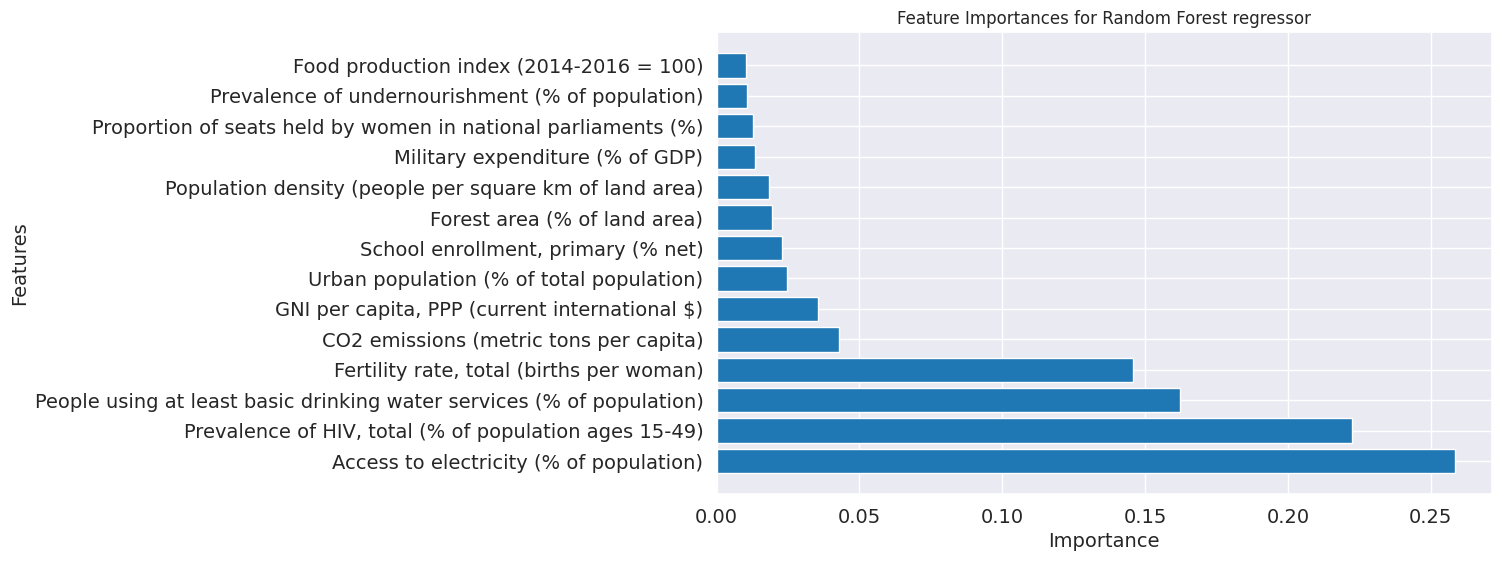

In [ ]:
best_rf_model = rf_cv_model.bestModel.stages[-1]
importances = best_rf_model.featureImportances
feature_list =train_df.columns[1:]

feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances in descending order based on importance values
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
print("Feature Importances for RF regressor:")
print("-----------------------------------------------------")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.4f}")

features = [feature for feature, _ in sorted_feature_importances]
importances = [importance for _, importance in sorted_feature_importances]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances for Random Forest regressor')
plt.show()

* `Access to electricity (% of population)` has the highest importance with a value of 0.2584. This indicates that this feature has the strongest impact on predicting life expectancy.
* `People using at least basic drinking water services (% of population)`and `Prevalence of HIV, total (% of population ages 15-49)` and  follow with importances of 0.1621 and 0.2226, respectively.
* The remaining features have decreasing importances, indicating their decreasing impact on predicting life expectancy.

###**Feature importance for linear regressor**

* The linear regressor allows access to the parameter vector which is a vector containing the weights for each feature. This vector does not explicitly include the parameter for the bias term (intercept).
* Based on the above parameter vector for the linear regressor and the corresponding feature names, we can analyse the impact of each feature on the linear regression model's predictions.

Feature Importances for Linear regressor:
-----------------------------------------------------
School enrollment, primary (% net): 0.0767
Military expenditure (% of GDP): 0.0669
Access to electricity (% of population): 0.0597
Prevalence of undernourishment (% of population): 0.0543
People using at least basic drinking water services (% of population): 0.0491
Proportion of seats held by women in national parliaments (%): 0.0303
Food production index (2014-2016 = 100): 0.0188
Urban population (% of total population): 0.0124
GNI per capita, PPP (current international $): 0.0004
Population density (people per square km of land area): -0.0015
Forest area (% of land area): -0.0052
Prevalence of HIV, total (% of population ages 15-49): -0.6659
CO2 emissions (metric tons per capita): -0.6921
Fertility rate, total (births per woman): -1.6091


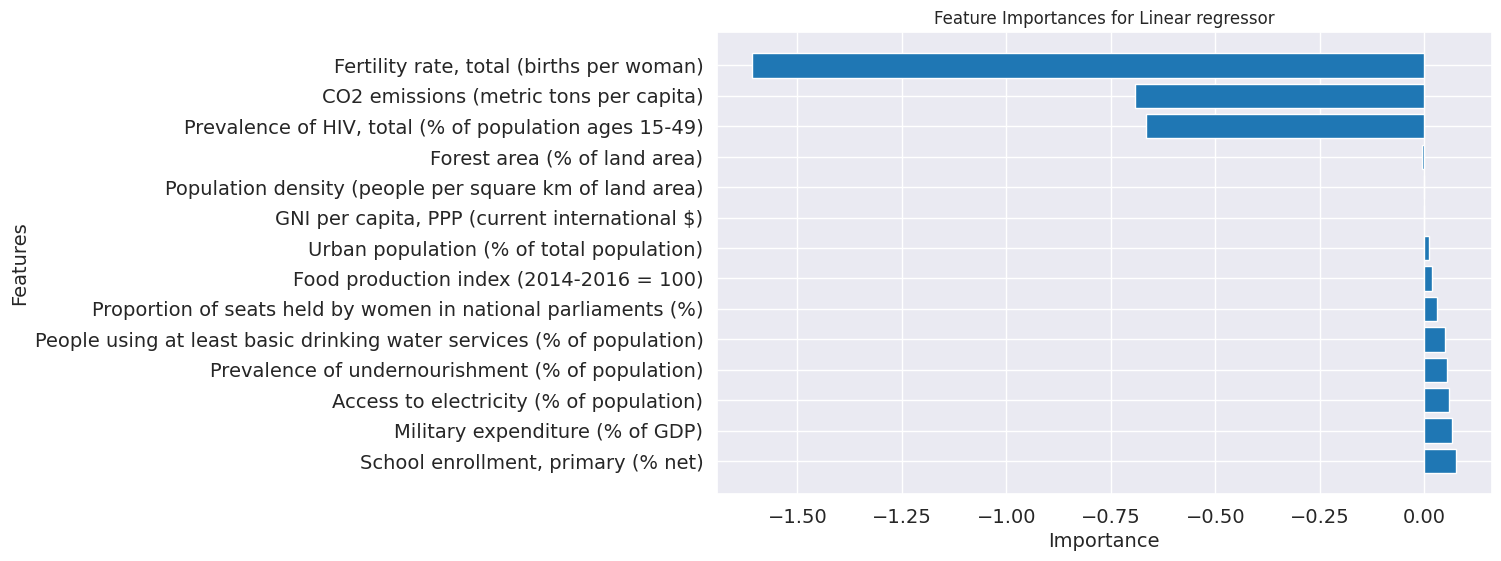

In [ ]:
params = cv_model.bestModel.stages[-1].coefficients
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, params)]

# Sort the feature importances in descending order based on importance values
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
print("Feature Importances for Linear regressor:")
print("-----------------------------------------------------")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.4f}")

# Extract the feature names and importance values
features = [feature for feature, _ in sorted_feature_importances]
importances = [importance for _, importance in sorted_feature_importances]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances for Linear regressor')
plt.show()


###**Observations**
* The linear regressor assigns different coefficients to each feature, indicating the linear relationship between each feature and the target variable. Positive coefficients indicate a positive relationship, while negative coefficients indicate a negative relationship.
* The linear regressor model above has the largest weight for `Fertility rate`. This indicates that the large negative relationship with the `target variable` heavily influences the prediction. Futhermore, the large negative weights for `CO2 emissions` and `Prevalence of HIV` play an important role in affecting the `life expectancy`
* The random forest regressor calculates feature importances based on the overall predictive influence of each feature. It considers interactions and also the mapping of nonlinear relationships between features and the target variable.
* The feature importances for the random forest regressor are all positive in this instance, indicating that these features have a positive impact on the target variable (Life Expectancy). On the other hand, the feature importances for the linear regressor include both positive and negative values. The negative importances indicate features that have a negative impact on the target variable.
* This suggests that the random forest regressor considers all the features as important contributors to the prediction (each feature has is modelled with a different importance which is learned through training), while the linear regressor assigns different weights to the features, including some with negative weights. The negative feature importances in the linear regressor indicate that those features have an inverse relationship with the target variable, meaning that as those features increase, the predicted life expectancy decreases.

##**Best Parameters**

###**Best Parameters of Random Forest Regressor**

* The best parameters for the Random Forest Regressor were obtained from the grid search using cross-validation and 'RMSE' metric.
* The grid was composed of 2 paramters :
  * `numTress` parameter which determines the number of decision trees, that are combined to create the final prediction. Increasing the number of trees can enhance the model's ability to capture complex relationships and improve its overall performance.
  * `maxDepth` parameter which determines the number of splits that each decision tree is allowed to make. A higher maxDepth allows the trees to have more splits and potentially capture more intricate patterns in the data.


* `numTrees` = 7 and `maxDepth` = 7 were the combination of parameters that performed best on evaluation metric used in the cross-validation process (RMSE).

For the random forest regression model, feature importance indicates the relative significance of each feature in predicting the `Life Expectancy`. The higher the feature importance value, the more influential the corresponding feature is in determining the Life Expectancy. As seen above, the following features, based on the trained random forest model with the best parameter values (numTrees = 7, maxDepth = 7), were found to have relatively higher importance:
  * `Access to electricity (% of population)`- This feature has the one of the highest weights. It suggests that access to electricity has a significant positive impact on Life Expectancy. Countries with a higher percentage of the population having access to electricity tend to have higher life expectancies.
  * `Prevalence of HIV, total (% of population ages 15-49)` - The importance of this feature suggests that the prevalence of HIV in the population has a significant impact on Life Expectancy. Lower HIV prevalence is associated with better health outcomes and higher life expectancy.
  * `People using at least basic drinking water services (% of population)` - With an importance of 0.1061, this feature suggests that access to basic drinking water services positively impacts Life Expectancy. Countries with a higher percentage of the population having access to clean drinking water tend to have higher life expectancies.

**These features are considered to have a stronger impact on Life Expectancy according to the random forest regression model.**

In [ ]:
best_params = rf_cv_model.bestModel.stages[-1].extractParamMap()

print("Best Parameters:")
for param, value in best_params.items():
    print(param.name, ": ", value)

Best Parameters:
bootstrap :  True
cacheNodeIds :  False
checkpointInterval :  10
featureSubsetStrategy :  auto
featuresCol :  features
impurity :  variance
labelCol :  label
leafCol :  
maxBins :  32
maxDepth :  11
maxMemoryInMB :  256
minInfoGain :  0.0
minInstancesPerNode :  1
minWeightFractionPerNode :  0.0
numTrees :  25
predictionCol :  prediction
seed :  7922636948988721163
subsamplingRate :  1.0


###**Best Parameters of Linear Regressor**

* The best values found were `regParam = 0.05` and `elasticNetParam = 0`. These parameters were determined through the cross-validation process using RMSE metric.
* The `regParam` parameter controls the regularization strength, and thus a value of 0.05 indicates a moderate regularization effect.
* The `elasticNetParam` parameter combines L1 and L2 regularization, and a value of 0 means that only L2 regularization is applied.

Highest positive Feature importances:
* `School enrollment, primary (% net)`: 0.0767.
This feature has a positive importance, indicating that an increase in primary school enrollment percentage has a positive impact on Life Expectancy. The magnitude of the importance suggests that this feature has a moderate influence on the prediction.

* `Military expenditure (% of GDP)`: 0.0669.
A positive importance implies that higher military expenditure as a percentage of GDP is associated with increased Life Expectancy. However, the magnitude of the importance suggests a relatively smaller impact compared to other features.

* `Access to electricity (% of population)`: 0.0597.
Positive importance suggests that better access to electricity positively affects Life Expectancy. The magnitude of the importance indicates a moderate influence.

Negative importance features which indicates a negative impact on Life Expectancy:
* Urban population (% of total population) (Importance: 0.0124)
* GNI per capita, PPP (current international $) (Importance: 0.0004)
* Population density (people per square km of land area) (Importance: -0.0015)
* Forest area (% of land area) (Importance: -0.0052)
* Prevalence of HIV, total (% of population ages 15-49) (Importance: -0.6659)
* CO2 emissions (metric tons per capita) (Importance: -0.6921)
* Fertility rate, total (births per woman) (Importance: -1.6091). This large negative weight means that the linear regressor has built a significant inverse relationship between this feature and the target variable. This means that higher fertility rates results in decreased life expectancy. This was seen in the regression plots in the EDA section

In [ ]:
best_params = cv_model.bestModel.stages[-1].extractParamMap()
#plot best parameters for the linear regressor model
print("Best Parameters:")
for param, value in best_params.items():
    print(param.name, ": ", value)

Best Parameters:
aggregationDepth :  2
elasticNetParam :  0.0
epsilon :  1.35
featuresCol :  features
fitIntercept :  True
labelCol :  label
loss :  squaredError
maxBlockSizeInMB :  0.0
maxIter :  100
predictionCol :  prediction
regParam :  0.05
solver :  auto
standardization :  True
tol :  1e-06


###**Observations**
* The random forest regressor considers all features as important, assigning positive importances to all features, whereas the linear regression model assigns both positive and negative importances to different features.
* The linear regression model assigns negative importances to some features, indicating an inverse relationship between those features and Life Expectancy, while the random forest regressor only considers positive importances.
* The random forest regressor places a higher positive importance on `Access to electricity` and `Prevalence of HIV` compared to the linear regression model.
* The linear regression model assigns higher positive importances to `School enrollment, primary (% net)` and `Military expenditure (% of GDP)` compared to the random forest regressor. However, has a large negative weight for `fertility rate`and `CO2 emissions` which greatly influences the prediction
* The random forest regressor includes more features with relatively higher importances compared to the linear regression model as was seen with the `Access to electricity` feature.
* The different regression models build different importances for each features. These importances influence their role in predicting the life expectancy
* It was determined that using the SDG indicators of varying importance to each model, life expectancy can be preidcted to a high degree of accuracy


# **7. Conclusion**

The Random Forest Regressor demonstrated the best predictive performance on the test set, achieving an RMSE of 0.958 and an Adjusted R2 of 0.979. These high values indicate that the model is able to predict life expectancy using SGD indicators with a high degree of accuracy. In contrast, the Linear Regressor exhibited lower performance (yet imppressive) on the test set with an RMSE of 2.445 and an Adjusted R2 of 0.863.

Analysing the feature importances, the Random Forest Regressor highlighted `access to electricity`, `prevalence of HIV`, and `basic drinking water services` as the most influential indicators. The Linear Regressor placed more importance on `primary school enrollment` and `military expenditure as a percentage of GDP`, but placed the largest importance on the negative relationship with `fertility rate`, `CO2 emissions` and `Prevalence of HIV`

The strengths of the Random Forest Regressor lie in its ability to handle complex relationships between features and the target variable, as well as its robustness against overfitting. However, the Linear Regressor's simplicity allows for interpretability and ease of implementation at the cost of simpler predicitve capabilities.

To improve the analysis, further exploration of the data and feature engineering techniques could be implemented. Additionally, considering other algorithms or ensemble methods may provide additional insights and enhance predictive accuracy.

Overall, this notebook demonstrates the potential of SDG indicators in predicting Life Expectancy. Further investigations and refinements to the models could yield valuable insights for policymakers and researchers aiming to understand the factors influencing Life Expectancy and guide interventions to improve global health outcomes.